In [9]:
# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# General imports
import os
import torch
import torch.quantization
import pytorch_lightning as pl
from copy import deepcopy
import random
random.seed(42)
import copy
torch.use_deterministic_algorithms(True)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model Specific imports
from meter.modules import METERTransformerSS


# Custom imports
import configs
from quantization_utils import get_module_by_path, quantize_modules
from quantization_utils import  SmallMTDataModuleMETER



In [15]:
# Set the configuration
_config = configs.meter_config_nlvr2
_config["batch_size"] = 32
_config["per_gpu_batchsize"] = 32
_config["learning_rate"] = 2e-4

# Set the PyTorch Lightning seed
pl.seed_everything(_config["seed"])

# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use

Seed set to 0


Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']
Test Dataloader Length:  4
Length of the first batch: 32
Shape of the first batch: torch.Size([32, 3, 288, 288])


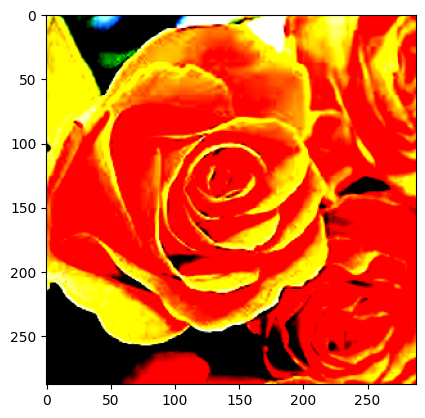

In [16]:
dm = SmallMTDataModuleMETER(_config, dist=False, num_samples=100)
dm.setup("test")
test_dataloader = dm.test_dataloader()

print("Test Dataloader Length: ", len(test_dataloader))

print(f"Length of the first batch: {len(next(iter(test_dataloader))['answers'])}")
print(f"Shape of the first batch: {next(iter(test_dataloader))['image_0'][0].shape}")

# Plot the first image from the first batch of the test and validation dataloaders
import matplotlib.pyplot as plt
plt.imshow(next(iter(test_dataloader))['image_0'][0][0].permute(1, 2, 0))
plt.show()


# Get the batch
for i, batch in enumerate(test_dataloader):
    if i == 0:
        break

# Register hooks

In [17]:
# Initialize a container to store features for all blocks
feature_container = {
    # Format: {block_idx: output_tensor}
    "student": {},
    "teacher": {}
}

def register_all_hooks(student_model, teacher_model):
    """Register hooks for all blocks in both models."""
    def _create_hook(container, model_type, block_idx):
        # Closure to capture the model_type and block_idx
        def hook(module, inp, out):
            container[model_type][block_idx] = out  # Store output tensor
        return hook

    teacher_model.cross_modal_text_pooler.dense.register_forward_hook(_create_hook(feature_container, "student", 0))
    student_model.cross_modal_text_pooler.dense.register_forward_hook(_create_hook(feature_container, "teacher", 0))
    
    # # Register hooks for every student block
    # for block_idx, block in enumerate(student_model.transformer.blocks):
    #     hook = _create_hook(feature_container, "student", block_idx)
    #     # block.mlp.fc2.register_forward_hook(hook)
    #     block.register_forward_hook(hook)

    # # Register hooks for every teacher block
    # for block_idx, block in enumerate(teacher_model.transformer.blocks):
    #     hook = _create_hook(feature_container, "teacher", block_idx)
    #     # block.mlp.fc2.register_forward_hook(hook)
    #     block.register_forward_hook(hook)

In [18]:
# =============== Initialize Full Precision Model ==============
teacher_model = METERTransformerSS(_config)
teacher_model.eval()

teacher_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)
teacher_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=2)

# student_model = ViLTransformerSS(_config)
# student_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'text_feats': tensor([[[ 0.9672,  1.2648, -1.9741,  ..., -0.8582, -0.9425,  0.6961],
          [-1.0586,  0.1197,  0.2884,  ..., -0.3385,  0.7035, -1.5265],
          [-1.4487,  0.0661,  0.8289,  ...,  0.0546,  0.1766, -1.3550],
          ...,
          [ 0.7890,  1.9490, -0.9578,  ..., -0.6669, -0.3340,  0.3740],
          [ 0.7890,  1.9490, -0.9578,  ..., -0.6669, -0.3340,  0.3740],
          [ 0.7890,  1.9490, -0.9578,  ..., -0.6669, -0.3340,  0.3740]],
 
         [[ 0.3542,  0.0708,  0.4457,  ...,  0.2468, -0.7386, -0.7349],
          [ 1.5149, -0.0028,  0.7262,  ..., -0.2807, -0.3244, -1.9186],
          [-1.1290,  0.2028,  0.3821,  ..., -0.2339, -0.2845, -0.6854],
          ...,
          [ 0.1196,  0.7407,  0.0819,  ..., -0.8199, -0.5532, -0.9767],
          [ 0.1196,  0.7407,  0.0819,  ..., -0.8199, -0.5532, -0.9767],
          [ 0.1196,  0.7407,  0.0819,  ..., -0.8199, -0.5532, -0.9767]],
 
         [[-0.0609,  0.0387,  0.1647,  ...,  0.2728, -0.1595, -0.0850],
          [-1.

# Quantize the student

In [20]:
for i in range(12):
    student_model = deepcopy(teacher_model)

    modules_to_train = {'layer_names': [f"text_transformer.encoder.layer.{i}.intermediate.dense",
                                        f"text_transformer.encoder.layer.{i}.output.dense",]
                        }

    # Quantize the model
    quantize_modules(student_model, modules_to_train['layer_names'], 4)

    register_all_hooks(student_model, teacher_model)

    student_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)
    teacher_model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)


    # Calculate the MSE between student and teacher features
    mse_container = {}
    for block_idx in feature_container["student"]:
        mse_container[block_idx] = torch.nn.functional.mse_loss(feature_container["student"][block_idx], feature_container["teacher"][block_idx])

    # Print the MSE values
    for block_idx, mse in mse_container.items():
        # print(f"Block: {block_idx} | MSE: {mse.item()}")
        print(f"Block {i} | MSE: {mse.item()}")

Block 0 | MSE: 0.005418951157480478
Block 1 | MSE: 0.011751733720302582
Block 2 | MSE: 0.1589585393667221
Block 3 | MSE: 0.1693955808877945
Block 4 | MSE: 0.08015384525060654
Block 5 | MSE: 0.04117881879210472
Block 6 | MSE: 0.08221382647752762
Block 7 | MSE: 0.04431268945336342
Block 8 | MSE: 0.030002379789948463
Block 9 | MSE: 0.03217548504471779
Block 10 | MSE: 0.016676902770996094
Block 11 | MSE: 0.0224496778100729


2bit -> We see the MSE scores represent the individual quantization accuracies of RoBERTa layers

Block 0 | MSE: 0.0020881849341094494

Block 1 | MSE: 0.022371865808963776

Block 2 | MSE: 0.011889171786606312

Block 3 | MSE: 0.01788029633462429

Block 4 | MSE: 0.026112010702490807

Block 5 | MSE: 0.011488492600619793

Block 6 | MSE: 0.020073844119906425

Block 7 | MSE: 0.005263203755021095

Block 8 | MSE: 0.007319341879338026

Block 9 | MSE: 0.018863923847675323

Block 10 | MSE: 0.005083068739622831

Block 11 | MSE: 0.00964327622205019

<------------------------------------------------------------>

When tested with 100 samples -> Indicates high input variability:

Block 0 | MSE: 0.0035035070031881332

Block 1 | MSE: 0.1446366310119629

Block 2 | MSE: 0.20990128815174103

Block 3 | MSE: 0.2315082997083664

Block 4 | MSE: 0.14286084473133087

Block 5 | MSE: 0.12811928987503052

Block 6 | MSE: 0.06563714891672134

Block 7 | MSE: 0.029317667707800865

Block 8 | MSE: 0.014658716507256031

Block 9 | MSE: 0.028861364349722862

Block 10 | MSE: 0.005771958734840155

Block 11 | MSE: 0.007566844578832388

4bit 8 samples:

Block 0 | MSE: 0.001748295035213232

Block 1 | MSE: 0.005294546019285917

Block 2 | MSE: 0.03192882612347603

Block 3 | MSE: 0.0111258365213871

Block 4 | MSE: 0.015013218857347965

Block 5 | MSE: 0.01699412614107132

Block 6 | MSE: 0.016989709809422493

Block 7 | MSE: 0.009856563992798328

Block 8 | MSE: 0.007909145206212997

Block 9 | MSE: 0.013289307244122028

Block 10 | MSE: 0.011227396316826344

Block 11 | MSE: 0.010999567806720734

<------------------------------------------------------------>

32 samples

Block 0 | MSE: 0.005418951157480478

Block 1 | MSE: 0.011751733720302582

Block 2 | MSE: 0.1589585393667221

Block 3 | MSE: 0.1693955808877945

Block 4 | MSE: 0.08015384525060654

Block 5 | MSE: 0.04117881879210472

Block 6 | MSE: 0.08221382647752762

Block 7 | MSE: 0.04431268945336342

Block 8 | MSE: 0.030002379789948463

Block 9 | MSE: 0.03217548504471779

Block 10 | MSE: 0.016676902770996094

Block 11 | MSE: 0.0224496778100729

In [29]:
# import matplotlib.pyplot as plt

# # Plot the first instance of the fusion layer output for each head
# for i in range(12):
#     # for j in range(8):
#     block = i
#     # head = j

#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#     fig.suptitle(f'Block: {block}', fontsize=16)
    
#     # Plot student features
#     im1 = axes[0].imshow(feature_container["student"][block].detach().cpu().numpy())
#     axes[0].set_title('Student')
#     fig.colorbar(im1, ax=axes[0])
    
#     # Plot teacher features
#     im2 = axes[1].imshow(feature_container["teacher"][block].detach().cpu().numpy())
#     axes[1].set_title('Teacher')
#     fig.colorbar(im2, ax=axes[1])
    
#     plt.tight_layout()
#     plt.show()